# DenoiSeg Example: Example Flywing data
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a membrane labeled developing Fly Wing dataset from our collaborators. This notebook can be used as a reference to train DenoiSeg networks on your own data.

In [1]:
# Here we are just importing some libraries which are needed to run this notebook.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision, compute_labels

from csbdeep.utils import plot_history
from tifffile import imread, imsave
from glob import glob

import urllib
import os
import zipfile

Using TensorFlow backend.


## Downloading and  Data Loading
We download a dataset consisting of noisy flywing images. The downloaded data creates a folder `MyData` and extracts within it three subfolders `train`, `val` and `test`. These folders have subfolders `raw` and `gt`. In `train/raw` folder, there are `1428` raw images and only the first `5` of raw images have ground truth annotations in folder `train/gt`. Similarly, in `val/raw` folder, there are `252` raw images and only the first `2` of raw images have ground truth annotations in folder `val/gt`. The `test` folder only has `raw` subfolder since these are the images we want denoised and segmented outputs for.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
link = 'https://owncloud.mpi-cbg.de/index.php/s/9ok6q1azniMJobq/download'

# check if data has been downloaded already
zipPath="data/MyData.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
# Loading of the training images
train_images = imread(sorted(glob("data/MyData/train/raw/*.tif")))
val_images = imread(sorted(glob("data/MyData/val/raw/*.tif")))
test_images = imread(sorted(glob("data/MyData/test/raw/*.tif")))
available_train_masks = imread(sorted(glob("data/MyData/train/gt/*.tif")))
available_val_masks = imread(sorted(glob("data/MyData/val/gt/*.tif")))

### Create zero images for missing masks

Here we create zero images for those training and validation images for which segmentation masks are not present. Then we use these zero images along with the images for which segmentation annotations are available for training the DenoiSeg network.

In [4]:
blank_images_train = np.zeros((train_images.shape[0]-available_train_masks.shape[0], available_train_masks.shape[1], available_train_masks.shape[2]))
blank_images_val = np.zeros((val_images.shape[0]-available_val_masks.shape[0], available_val_masks.shape[1], available_val_masks.shape[2]))
blank_images_train = blank_images_train.astype("uint16")
blank_images_val = blank_images_val.astype("uint16")

train_masks = np.concatenate((available_train_masks,blank_images_train), axis = 0)
val_masks = np.concatenate((available_val_masks,blank_images_val), axis = 0)

## Data Preprocessing
We do some necessary data preprocessing in the cell below such as augmenting training data; extracting foreground, background and border classes from our training and validation masks.

In [5]:
# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(train_images, train_masks)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (11424, 128, 128)
Mask size after augmentation (11424, 128, 128)
Shape of X:     (11424, 128, 128, 1)
Shape of Y:     (11424, 128, 128, 3)
Shape of X_val: (252, 128, 128, 1)
Shape of Y_val: (252, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

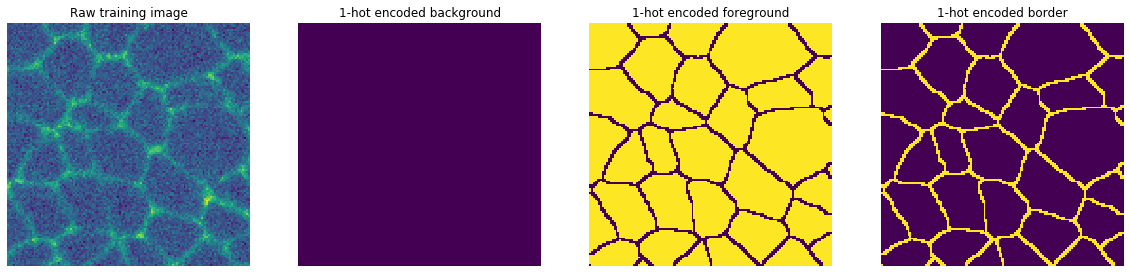

In [6]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw training image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

### Configure network parameters

In [7]:
train_batch_size = 128
train_steps_per_epoch = min(400, max(int(X.shape[0]/train_batch_size), 10))

In [8]:
### In the next cell, you can choose how much relative importance (weight) to assign to denoising 
### and segmentation tasks by choosing appropriate value for denoiseg_alpha (between 0 and 1; with 0 being
### only segmentation and 1 being only denoising. Here we choose denoiseg_alpha = 0.5)

In [9]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=120, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['44.541298'],
 'stds': ['43.985756'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 120,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [10]:
model_name = 'DenoiSeg_Practicalfinal_n20'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

Loading network weights from 'weights_best.h5'.


In [11]:
history = model.train(X, Y, (X_val, Y_val))

Preparing validation data:   1%|          | 3/252 [00:00<00:10, 23.34it/s]

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 252/252 [00:08<00:00, 30.94it/s]


Epoch 1/120
100/100 [==============================] - 96s 956ms/step - loss: 0.1863 - denoiseg: 0.1863 - seg_loss: 0.0028 - denoise_loss: 0.1836 - val_loss: 0.1536 - val_denoiseg: 0.1536 - val_seg_loss: 0.0060 - val_denoise_loss: 0.1477
Epoch 2/120
100/100 [==============================] - 95s 954ms/step - loss: 0.1312 - denoiseg: 0.1312 - seg_loss: 0.0022 - denoise_loss: 0.1290 - val_loss: 0.1388 - val_denoiseg: 0.1388 - val_seg_loss: 0.0049 - val_denoise_loss: 0.1339
Epoch 3/120
100/100 [==============================] - 120s 1s/step - loss: 0.1280 - denoiseg: 0.1280 - seg_loss: 0.0018 - denoise_loss: 0.1261 - val_loss: 0.1328 - val_denoiseg: 0.1328 - val_seg_loss: 0.0043 - val_denoise_loss: 0.1286
Epoch 4/120
100/100 [==============================] - 120s 1s/step - loss: 0.1258 - denoiseg: 0.1258 - seg_loss: 0.0016 - denoise_loss: 0.1242 - val_loss: 0.1360 - val_denoiseg: 0.1360 - val_seg_loss: 0.0040 - val_denoise_loss: 0.1320
Epoch 5/120
100/100 [==============================]

Epoch 35/120
100/100 [==============================] - 120s 1s/step - loss: 0.1207 - denoiseg: 0.1207 - seg_loss: 7.5054e-04 - denoise_loss: 0.1200 - val_loss: 0.1189 - val_denoiseg: 0.1189 - val_seg_loss: 0.0020 - val_denoise_loss: 0.1169
Epoch 36/120
100/100 [==============================] - 111s 1s/step - loss: 0.1206 - denoiseg: 0.1206 - seg_loss: 7.2626e-04 - denoise_loss: 0.1199 - val_loss: 0.1192 - val_denoiseg: 0.1192 - val_seg_loss: 0.0020 - val_denoise_loss: 0.1172
Epoch 37/120
100/100 [==============================] - 121s 1s/step - loss: 0.1204 - denoiseg: 0.1204 - seg_loss: 7.6862e-04 - denoise_loss: 0.1196 - val_loss: 0.1191 - val_denoiseg: 0.1191 - val_seg_loss: 0.0019 - val_denoise_loss: 0.1172
Epoch 38/120
100/100 [==============================] - 120s 1s/step - loss: 0.1205 - denoiseg: 0.1205 - seg_loss: 7.8616e-04 - denoise_loss: 0.1197 - val_loss: 0.1202 - val_denoiseg: 0.1202 - val_seg_loss: 0.0020 - val_denoise_loss: 0.1182
Epoch 39/120
100/100 [==============

100/100 [==============================] - 120s 1s/step - loss: 0.1202 - denoiseg: 0.1202 - seg_loss: 7.8729e-04 - denoise_loss: 0.1194 - val_loss: 0.1183 - val_denoiseg: 0.1183 - val_seg_loss: 0.0019 - val_denoise_loss: 0.1164
Epoch 102/120
100/100 [==============================] - 121s 1s/step - loss: 0.1197 - denoiseg: 0.1197 - seg_loss: 6.0412e-04 - denoise_loss: 0.1191 - val_loss: 0.1182 - val_denoiseg: 0.1182 - val_seg_loss: 0.0019 - val_denoise_loss: 0.1164

Epoch 00102: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 103/120
100/100 [==============================] - 104s 1s/step - loss: 0.1200 - denoiseg: 0.1200 - seg_loss: 7.7792e-04 - denoise_loss: 0.1192 - val_loss: 0.1183 - val_denoiseg: 0.1183 - val_seg_loss: 0.0019 - val_denoise_loss: 0.1164
Epoch 104/120
100/100 [==============================] - 111s 1s/step - loss: 0.1196 - denoiseg: 0.1196 - seg_loss: 5.8982e-04 - denoise_loss: 0.1190 - val_loss: 0.1183 - val_denoiseg: 0.1183 - val_seg_loss: 

In [12]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'lr'])

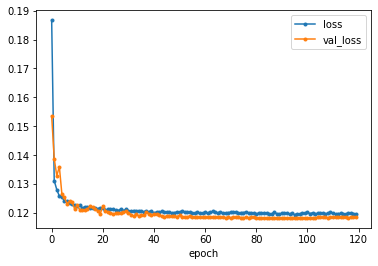

In [13]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [14]:
threshold, val_score = model.optimize_thresholds(val_images[:available_val_masks.shape[0]].astype(np.float32), val_masks, measure=measure_precision())

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


Score for threshold = 0.10 is 0.0000
Score for threshold = 0.15 is 0.2323
Score for threshold = 0.20 is 0.7457
Score for threshold = 0.25 is 0.8858
Score for threshold = 0.30 is 0.8945
Score for threshold = 0.35 is 0.8705
Score for threshold = 0.40 is 0.8631
Score for threshold = 0.45 is 0.8699
Score for threshold = 0.50 is 0.8699
Score for threshold = 0.55 is 0.8545
Score for threshold = 0.60 is 0.8262
Score for threshold = 0.65 is 0.8262
Score for threshold = 0.70 is 0.8262
Score for threshold = 0.75 is 0.8262
Score for threshold = 0.80 is 0.8195
Score for threshold = 0.85 is 0.7996
Score for threshold = 0.90 is 0.7359
Score for threshold = 0.95 is 0.6758
Score for threshold = 1.00 is 0.0000

The higest score of 0.895 is achieved with threshold = 0.30000000000000004.


## Test Data
Finally we load the test data and run the prediction.

In [15]:
denoised_images = []
segmented_images = []

for i in range(test_images.shape[0]):
    predicted_channels = model.predict(test_images[i].astype(np.float32), axes='YX')
    denoised_images.append(predicted_channels[...,0])
    segmented_images.append(compute_labels(predicted_channels, threshold))

### Visualize the results

<Figure size 432x288 with 0 Axes>

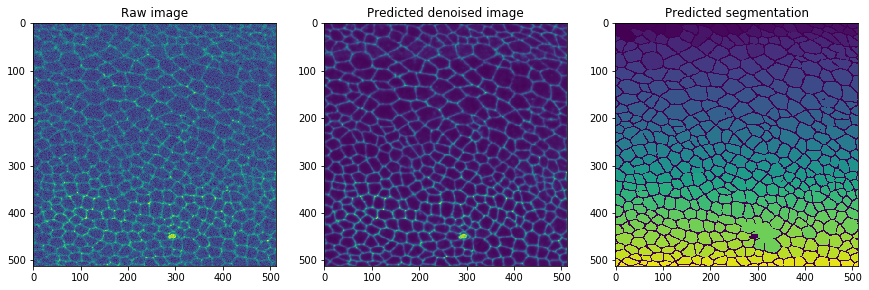

In [16]:
sl = 6
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
plt.imshow(test_images[sl])
plt.title("Raw image")

plt.subplot(1, 4, 2)
plt.imshow(denoised_images[sl])
plt.title("Predicted denoised image")

plt.subplot(1, 4, 3)
plt.imshow(segmented_images[sl], cmap = "viridis")
plt.title("Predicted segmentation")

plt.show()

### Export your model for Fiji

In [ ]:
model.export_TF(name='DenoiSeg - YourOwnData Example', 
                description='This is the 2D DenoiSeg example trained on YourOwnData in python.', 
                authors=["You"],
                test_img=X_val[0,...,0], axes='YX',
                patch_shape=(128, 128))